# Анализ факторов успешности компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Цель: отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Изучение данных

Для начала импортируем необходимые библиотеки:

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import math as mt
from math import factorial

! pip install scipy  -U
from scipy import stats as st

! pip install seaborn -U
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# отображение формата float
pd.set_option('display.float_format', '{:.2f}'.format)
# отображение всех столбцов таблиц
pd.set_option('display.max_columns', None)

Загрузим данные и сохраним их в DataFrame `df`, после чего изучим более детально:

In [3]:
df = pd.read_csv('/Users/anastasia/Documents/YandexPractikum/СП-1/games.csv')

In [4]:
# посмотри первые и последние 5 строк таблицы
display(df.head())
display(df.tail())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.00,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN


In [5]:
print('Таблица включает в себя {} строк и {} столбцов'.format(df.shape[0], df.shape[1]))

Таблица включает в себя 16715 строк и 11 столбцов


In [6]:
# посморим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таким образом, видим, что таблицв включает в себя 11 переменных, среди которых следующие: 

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Вывод**

Отметим несколько моментов на основе беглого взгляда на данные: 
1. Для некоторых переменых присутствует меньше значений, чем в целом по датасету. Это говорит о наличии в них пропущенных значений; 
2. Нужно проверить на наличие дубликатов;
3. Нужно будет скорректировать названия столбцов (привести к нижнему регистру);
4. Заменить типы данных для некоторых переменных (`Year_of_Release`, `User_Score`, `Critic_Score`);
5. Стоит проверить текстовые значения на уникальность, чтобы исключить использование разных названий для одного предмета;


## Подготовка данных

### Переименование столбцов

Для начала переименуем столбцы - для удобства приведем их к нижнему регистру (единому формату):

In [7]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Изменение типа данных

1. В данных есть данные года выпуска игры `year_of_release`, которые сейчас имеют тип данных `float`, приведем его к типу даных `datetime`, чтобы была возможность оперировать с этим столбцом как со столбцом дат при необходимости:

In [8]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

2. Кроме того, столбец `user_score` по логике должен быть типом данных `float`, но из-за наличия в данных текстовых значений "tbd" он принимает тип данных `object`. 

Чтобы понять, что это значит, мы воспользовались поисковиком. Можем судить, что это аббревиатура tbd = to be decided/to be determined. Иными словами, аббревиатура означает, что рейтинг пока еще не определен, то есть у нас нет этих данных. Уместным решением в такой ситуации может быть заменить эти значения на пропуски: NaN.

In [9]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

3. Наконец, обратим внимание на переменную `critic_score`, которая принимает только целые значения от 0 до 100. Ее можно привести к типу данных `int`.

In [10]:
df['critic_score'] = df['critic_score'].astype('Int64')

### Заполнение пропусков

Для начала посмотрим на пропуски в данной таблице: 

In [11]:
df_na = df.isna().sum().sort_values(ascending=False)

for number in range(len(df_na)):
    if df_na[number] != 0:
        print('Доля пропусков в {} равна {:.2%}'.format(df_na.index[number], df_na[number]/df.shape[0]))

Доля пропусков в user_score равна 54.59%
Доля пропусков в critic_score равна 51.32%
Доля пропусков в rating равна 40.48%
Доля пропусков в year_of_release равна 1.61%
Доля пропусков в name равна 0.01%
Доля пропусков в genre равна 0.01%


Можно увидеть, что больше всего пропусков у пользовательских оценок `user_score`. Это может быть связано с тем, что пользователи часто не хотят тратить время на выставление рейтинга и пропускают этот шаг/опрос/ и т.д.

Для отсутствия оценок критиков `critic_score` и возрастного рейтинга `rating` игр сложно вывести единый фактор. Вероятно, на ресурсах, откуда были полученны эти данные, эти показатели также просто отсутствовали. 

Точечные пропуски в названиях `name` и жанрах `genre`, вероятно, связаны с технической потерей информации или тем, что она и не была внесена в базу данных. 


1. Посмотри на столбцы с наименьшей долей пропусков:

In [12]:
display(df.loc[df['name'].isna()])
display(df.loc[df['genre'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Отметим, что здесь присутствуют лишь 2 строки и они пересекаются. Эти данные заполнить самостоятельно в соответствии с логикой мы не сможем, а без заполнения они малоинформативны. 

По той же причине удалим строки с пропусками в переменной `year_of_release`, так как их небольшая доля и мы не потеряем значимую информацию:

In [13]:
df.dropna(subset=['name', 'genre', 'year_of_release'], axis=0, inplace = True)

2. Посмотрим на `critic_score` и `user_score`. Самым очевидным было бы заполнить тот или иной рейтинг медианными значениями в зависимости от других оценок критиков/пользователей/ESRB, соответсвенно, но это не поможет, так как большинство строк среди них пересекаются. Это можно увидеть, если посмотреть на размер отдельных и пересекающиеся массивов:

In [14]:
# пропуски по каждому отдельному столбцу
display(df.loc[df['critic_score'].isna()].shape)
display(df.loc[df['rating'].isna()].shape)
display(df.loc[df['user_score'].isna()].shape)

(8461, 11)

(6676, 11)

(8981, 11)

In [15]:
# пропуски по всем столбцам
df.loc[df['rating'].isna() | df['user_score'].isna() | df['critic_score'].isna()].shape

(9618, 11)

В таком случае, в качестве некоторого индикатора востребованности игры можно использовать данные по продажам.

Рассчитаем суммарные продажи во всех регионах:

In [16]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Напишем цикл для заполнения пропусков медианными значениями: 

In [17]:
# Создадим функцию "median_count" для подсчета медианы для среза с учетом определенных условий
# На вход функция принимает 4 переменных: "column_for_median" - столбец по которому будет считаться медиана, 
# "column" - столбец, на который накладывается условие, для "metric1" и "metric2" задаем в качестве промежутка данных - 
# квартили, полученные через метод describe(), чтобы получить наиболее равномерную группировку. На вход в этих переменных 
# вносим числа от 3 (min) до 7 (max). 
# На выходе функция возвращает переменную "median" - посчитанную медиану

def median_count(column_for_median, column, metric1, metric2):
    median = df.loc[
        (~df[column_for_median].isna()) &
        (df[column] >= df[column].describe()[metric1]) &
        (df[column] <= df[column].describe()[metric2]), column_for_median].median()
    return median

In [18]:
# разделим данные по общим продажам из предположения, что оценки и продажи будут меняться пропорционально

series_list = ['critic_score', 'user_score']

for column in series_list: 
    # min - 25%
    median25 = median_count(column, 'total_sales', 3, 4)
    df.loc[(df[column].isna()) & (df['total_sales'] >= df['total_sales'].describe()[3]) &
           (df['total_sales'] <= df['total_sales'].describe()[4]), column] = median25
    # 25% - 50%
    median50 = median_count(column, 'total_sales', 4, 5)
    df.loc[(df[column].isna()) & (df['total_sales'] >= df['total_sales'].describe()[4]) &
           (df['total_sales'] <= df['total_sales'].describe()[5]), column] = median50
    # 50% - 75%
    median75 = median_count(column, 'total_sales', 5, 6)
    df.loc[(df[column].isna()) & (df['total_sales'] >= df['total_sales'].describe()[5]) &
           (df['total_sales'] <= df['total_sales'].describe()[6]), column] = median75
    # 75% - max
    median100 = median_count(column, 'total_sales', 6, 7)
    df.loc[(df[column].isna()) & (df['total_sales'] >= df['total_sales'].describe()[6]) &
           (df['total_sales'] <= df['total_sales'].describe()[7]), column] = median100
    print(df[column].isna().sum())

0
0


3. Посмотрим на переменную `rating`. Оставим здесь пропуски или заполним на дополнительную категорию "unknown", так как переменная принимает текстовые значения о возрастной категории игр, которые нельзя заполнить "на глаз", при этом их слишком много, чтобы удалять. Эти данные нужно уточнять у коллег.

In [19]:
df['rating'] = df['rating'].fillna(value='unknown')

При этом проведем некоторую подготовительную работу с переменной. Если посмотреть на уникальные значения, то можно отметить, что там присутствуют как рейтинг `E`, так и `K-A`. Оба сокращения означают, что игра предназначена для всех возрастов, но эти обозначения использовались в разные годы. Заменим `K-A` на актуальное обозначение `E`:

In [20]:
display(df['rating'].unique())
df['rating'].replace('K-A', 'E', inplace=True)

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Кроме того, для удобства создадим числовой столбец для рейтинга, то есть присвоим каждому текстовому значению числовое. 

In [21]:
# разделим на категории
rating_dict = df['rating']

rating_dict = rating_dict.drop_duplicates().reset_index(drop=True)
rating_dict = rating_dict.reset_index()
print(rating_dict)

   index   rating
0      0        E
1      1  unknown
2      2        M
3      3        T
4      4     E10+
5      5       AO
6      6       EC
7      7       RP


In [22]:
# объединим таблицы для заполнения числового столбца 'rating_id'
df = df.merge(rating_dict, left_on='rating', right_on='rating')
df = df.rename(columns = {'index':'rating_id'})
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_id
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.00,E,82.54,0
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.30,E,35.52,0
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.00,E,32.77,0
3,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.50,E,29.80,0
4,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.60,E,28.91,0


In [23]:
# проверим теперь число пропусков
print(df.isna().sum())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
rating_id          0
dtype: int64


In [24]:
# проверим наличие дубликатов
print(df.duplicated().sum())

0


**Вывод**

На данном этапе данные были устранены основные проблемы, которые мы увидели при первом взгляде на данные:
- Названия столбцов были приведены к унифицированному виду;
- Были применены типы данных, соответствующие фактическому формату данных: даты к `datatime`, рейтинг, принимающий дробные значения к формату `float`, рейтинг принимающий только целые значения к формату `int`;
- Были устранены пропуски в тех переменных, где это можно было сделать в соответствии с логикой. Там, где восстановить данные не удалось были либо удалены строки, если не терялась значимая информация, либо пока оставлены пропуски;
- Возрастные категории были актуализированы к используемым на сегодняхний день обозначениям;
- Был рассчитан общий объем продаж в мире, а также введены числовые категории для возрастных рейтингов;
- Данные были проверены на наличие дубликатов.

## Исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы.

In [25]:
# свобдная таблица для количества игр по годам
game_year = df.pivot_table(index='year_of_release', values='name', aggfunc=['count']).reset_index()
game_year.columns = ['year', 'games_count']
game_year.reset_index().head()

,index,year,games_count
0,0,1980,9
1,1,1981,46
2,2,1982,36
3,3,1983,17
4,4,1984,14


<AxesSubplot:title={'center':'Количество выпущенных игр в зависимости от года'}, xlabel='Год', ylabel='Выпущенные игры'>

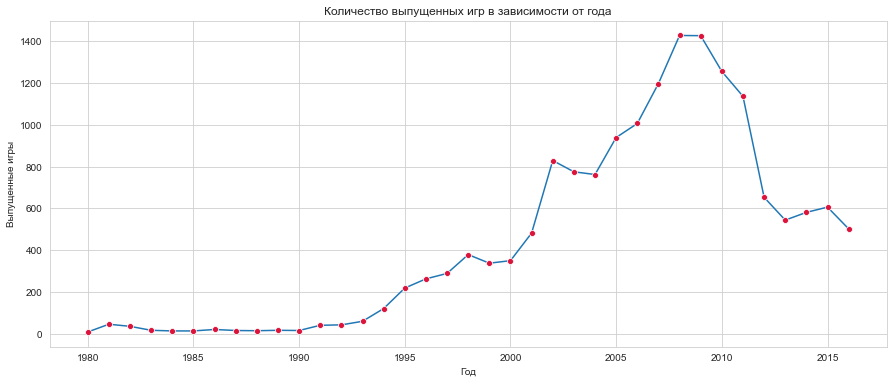

In [26]:
# линейный график временного ряда
plt.figure(figsize = (15,6))
sns.set_style('whitegrid')


line = sns.lineplot(data=game_year,
                    x='year',
                    y='games_count',
                    marker='o',
                    markerfacecolor='crimson',
                    dashes=False,
                    palette='black',
                    )

line.set_title('Количество выпущенных игр в зависимости от года')
line.set_xlabel('Год')
line.set_ylabel('Выпущенные игры')

display(line)

<AxesSubplot:title={'center':'Количество выпущенных игр в зависимости от года'}, xlabel='Год', ylabel='Выпущенные игры'>

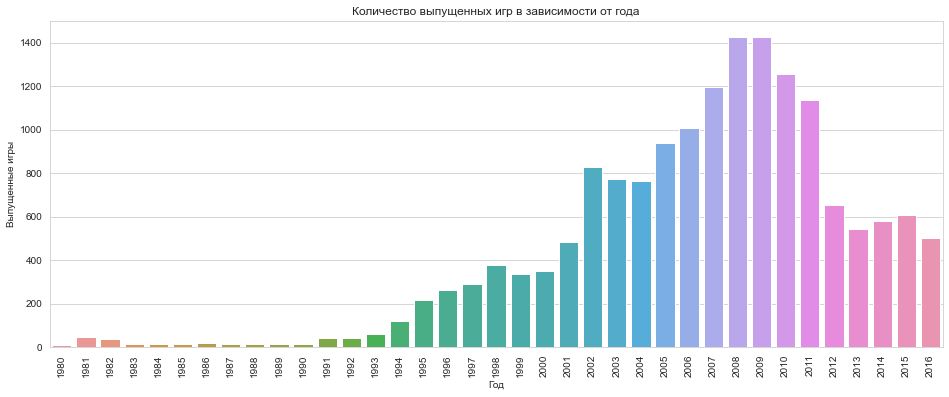

In [27]:
# столбчатая диаграмма по производству за года
plt.figure(figsize = (16,6))
sns.set_style('whitegrid')

bar = sns.barplot(data=game_year,
                  x='year',
                  y='games_count',)


#bar.autofmt_xdate(rotation=90)
#bar.autofmt_xdate()
#bar.fmt_xdata = mdates.DateFormatter('%Y')


plt.xticks(rotation=90)


bar.set_title('Количество выпущенных игр в зависимости от года')
bar.set_xlabel('Год')
bar.set_ylabel('Выпущенные игры')

display(bar)

Исходя из выше приведенных графиков, можно заметить, что динамика производства игр различается. До 2002 г. производилось сравнительно немного игр, после чего начался рост их производства. Пик приходится на 2008-2009 гг. Начиная же с 2012 г. объем производства установился на примерно постоянном уровне, который сохраняется до 2016 г. 

Здесь можно отметить, что для прогноза на 2017 г. для нас информативными будут именно последние годы со стабильной динамикой, так как можно предположить, что в структуре спроса на рынке произошли какие-то изменения после чего последовал такой спад в производстве. А значит пиковые значения предыдущих лет уже не будут отражать актуальную ситуацию.

### Посмотрим, как менялись продажи по платформам. 

Для начала выберем платформы с наибольшими суммарными продажами:

In [28]:
# свобдная таблица для общих продаж по платформам

platform_sales = (df.pivot_table(index='platform', values='total_sales', aggfunc=['sum'])
                  .sort_values(by=[('sum', 'total_sales')], ascending=False)
                  .reset_index()
                 )
platform_sales.columns = ['platform', 'total_sales']
platform_sales.head()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78


<AxesSubplot:title={'center':'Объем продаж в зависимости от типа платформы'}, xlabel='Платформа', ylabel='Объем продаж'>

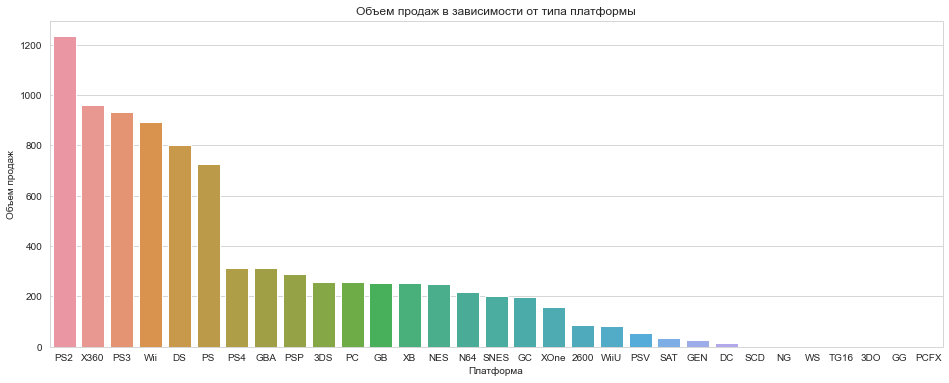

In [29]:
# столчатая диаграмма по объемам продаж с каждой платформы
plt.figure(figsize = (16,6))
sns.set_style('whitegrid')

bar = sns.barplot(data=platform_sales,
                  x='platform',
                  y='total_sales',
                  #order=platform_sales.sort_values('total_sales', ascending=False)['platform']
                  )

bar.set_title('Объем продаж в зависимости от типа платформы')
bar.set_xlabel('Платформа')
bar.set_ylabel('Объем продаж')

display(bar)

На основании графика можно увидеть, что наибольший вклад в продажи вносят игры, вышедшие на первых 6 платформах. Рассмотрим, как изменялась динамика их продаж на протяжении существования магазина:

In [30]:
# свобдная таблица для общих продаж по годам по платформам 
platform_sales_year = df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc=['sum'])


# выделим платформы с наибольшими продажами, которые мы нашли ранее
top_platform_sales_by_year = platform_sales_year[[('sum',   'DS'), ('sum',   'PS'), ('sum',  'PS2'),
                                     ('sum',  'PS3'), ('sum',  'Wii'), ('sum', 'X360')]]

top_platform_sales_by_year.columns = ['DS','PS','PS2','PS3','Wii','X360']

top_platform_sales_by_year.reset_index().head()

,year_of_release,DS,PS,PS2,PS3,Wii,X360
0,1980,NaN,NaN,NaN,NaN,NaN,NaN
1,1981,NaN,NaN,NaN,NaN,NaN,NaN
2,1982,NaN,NaN,NaN,NaN,NaN,NaN
3,1983,NaN,NaN,NaN,NaN,NaN,NaN
4,1984,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Объем продаж в зависимости от типа платформы'}, xlabel='Год', ylabel='Общиее продажи'>

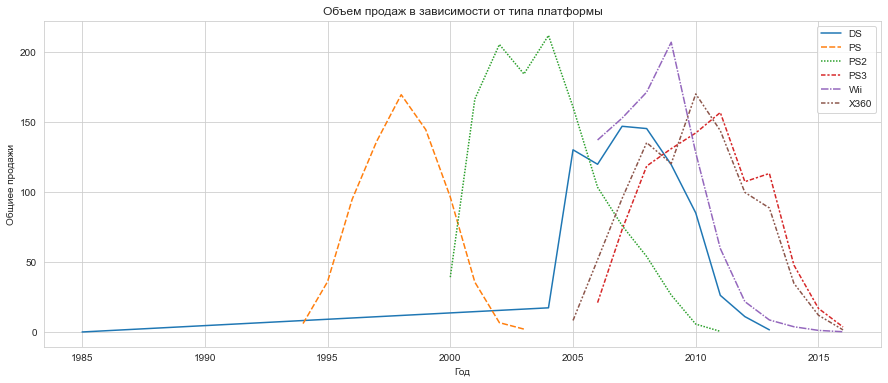

In [31]:
# линейные графики для топовых платформ (динамика во времени)

plt.figure(figsize = (15,6))
sns.set_style('whitegrid')


line = sns.lineplot(data=top_platform_sales_by_year)

line.set_title('Объем продаж в зависимости от типа платформы')
line.set_xlabel('Год')
line.set_ylabel('Общиее продажи')

display(line)

In [32]:
# посмотри на жизненный цикл в целом всех платформ 
all_platform_sales = df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc=['sum']).reset_index()

all_platform_sales.groupby(('platform','')).count().sum().median()

7.0

Как видно из графика и данных, для платформ с наибольшими продажами типичен цикл около 10-12 лет. При этом, если посмотреть на медианный промежуток жизни для всех платформ в целом, то там срок короче - 7 лет.

На основании проведенного анализа, можем выделить в качестве актуального периода промежутов времени с 2012 г. Как уже упоминалось ранее, начиная с этого года производство вышло на стабильный уровень и значительно не менялось. Следовательно, данные за этот период будут достаточно надежными, чтобы сформировать план на 2017 г., так как отражают общую актуальную ситуацию. 

Сделаем срез:

In [33]:
df_actual = df.loc[df['year_of_release'] >= 2012]

### Рассмотрим также на актуальном временном промежутке поведение всех платформ в целом: 

In [34]:
# свободная таблица для общих продаж по годам по платформам для актуального периода
platform_sales_actual = df_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc=['sum'])
platform_sales_actual.columns = ['3DS', 'DS', 'PC', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']
platform_sales_actual

,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


<AxesSubplot:title={'center':'Объем продаж в зависимости от типа платформы'}, xlabel='Год', ylabel='Общиее продажи'>

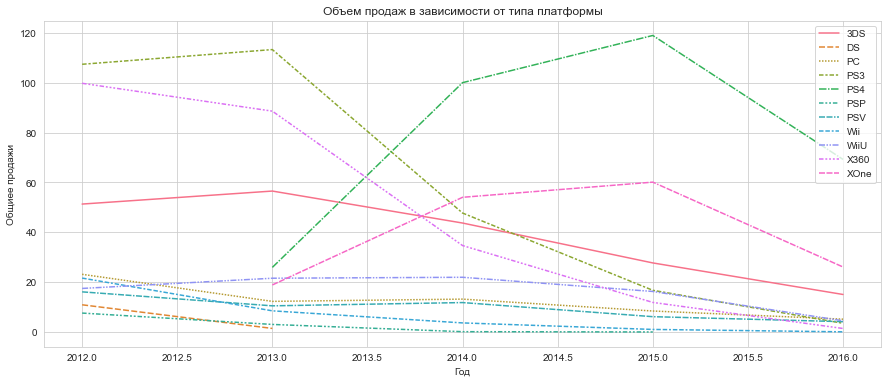

In [35]:
# линейные графики для всех платформ (динамика на актуальном периоде)

plt.figure(figsize = (15,6))
sns.set_style('whitegrid')

line = sns.lineplot(data=platform_sales_actual)

line.set_title('Объем продаж в зависимости от типа платформы')
line.set_xlabel('Год')
line.set_ylabel('Общиее продажи')

display(line)

Исходя из графика можно отметить, что лидируют по продажам платформы `PS4`, `XOne`, `3DS`. При этом для большинства платформ уже пройден пик продажи (отталкиваясь от ранее выделенного нами жизненного цикла) и продажи постепенно снижаются. 

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

Еще раз выделим топ-5 платформ, теперь уже на нужном нам периоде: 

In [36]:
# сводная таблица за актуальный период
df_platform_sales_actual = (df_actual.pivot_table(index='platform', values='total_sales', aggfunc=['sum'])
                  .reset_index())
df_platform_sales_actual.columns = ['platform', 'total_sales']

# топ-5 платформ
df_platform_sales_actual.sort_values(by='total_sales', ascending=False)

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32
8,WiiU,82.19
2,PC,62.65
6,PSV,49.18
7,Wii,35.37
1,DS,12.55


<AxesSubplot:title={'center':'Диаграмма разброса общих продаж в зависимости от платформы'}, xlabel='Платформа', ylabel='Общиее продажи'>

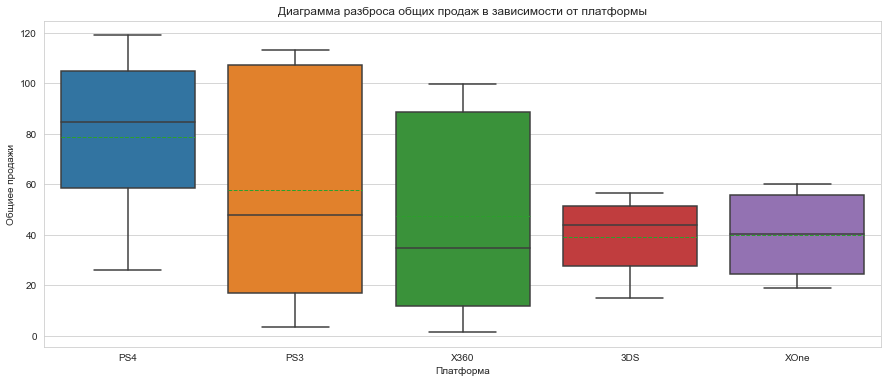

In [37]:
# выделим интересующие нас платформы
top_platform_sales_actual = platform_sales_actual[['PS4', 'PS3', 'X360', '3DS','XOne']]

# построим диаграмму размаха
sns.set_style('whitegrid')
plt.figure(figsize = (15,6))

boxplot = sns.boxplot(data=top_platform_sales_actual, meanline=True, showmeans=True,)

boxplot.set_title('Диаграмма разброса общих продаж в зависимости от платформы')
boxplot.set_xlabel('Платформа')
boxplot.set_ylabel('Общиее продажи')

display(boxplot)

В первую очередь, по данным видно, что в выбранном срезе данных нет выбросов (из-за небольшого числа оставшихся наблюдений). 

- Можно отметить, что как наибольшие максимальные и минимальные продажи игр осуществляются для платфоры `PS4`, для которой также отмечается наибольший размах. Медиана здесь выше среднего значения, что говорит о присутствии в данных нетипично малых значений продаж, которые тянут среднее вниз. Это же подтверждает значение 1ого квартиля.

- Наибольший квартильный же размах отмечается для платформ `PS3` и `X360`. Медиана здесь ниже среднего значения, что говорит о присутствии в данных нетипично больших значений продаж, которые тянут среднее вверх. Об этом же говорит высокий 3ий квартиль.

- Для платформы `3DS` наблюдаются наименьшие максимальные и минимальные продажи игр. Медиана здесь выше среднего значения. 

- Для платформы `XOne` медиана совпадает со средним, значит данные достаточно равномерно распределены.




### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами для наиболее популярной платформы `PS4`:

In [38]:
# отфильтруем по платформе
df_ps4 = df_actual.query('platform == "PS4"')

In [39]:
# корреляционная матрица
df_ps4[['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.00,-0.04,0.41
user_score,-0.04,1.00,0.49
critic_score,0.41,0.49,1.00


In [40]:
df_ps4[['total_sales', 'user_score', 'critic_score']].describe()

,total_sales,user_score,critic_score
count,392.00,392.00,392.00
mean,0.80,6.97,71.00
std,1.61,1.22,10.48
min,0.01,1.50,19.00
25%,0.06,6.60,66.00
50%,0.20,7.30,69.00
75%,0.73,7.70,78.00
max,14.63,9.20,97.00


<AxesSubplot:title={'center':'Зависимость продаж от отзывов пользователей'}, xlabel='Пользовательский рейтинг', ylabel='Общиее продажи'>

<AxesSubplot:title={'center':'Зависимость продаж от отзывов критиков'}, xlabel='Рейтинг критиков', ylabel='Общиее продажи'>

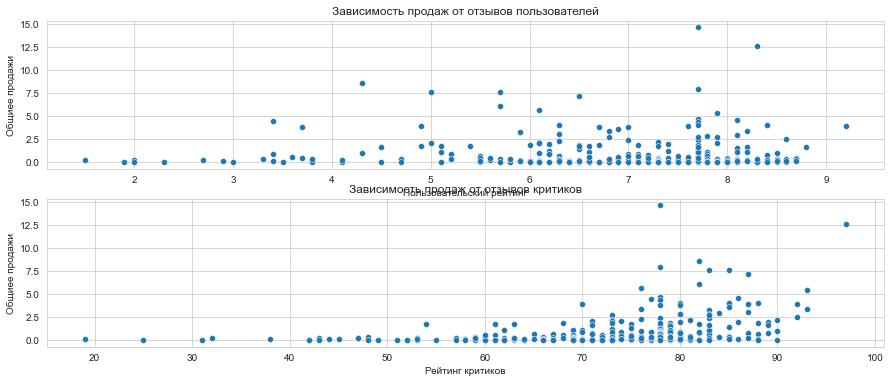

In [41]:
# диаграмма рассеяния 

sns.set_style('whitegrid')
plt.figure(figsize = (15,6))

plt.subplot(2, 1, 1)
scatter1 = sns.scatterplot(data=df_ps4, x='user_score', y='total_sales') 

scatter1.set_title('Зависимость продаж от отзывов пользователей')
scatter1.set_xlabel('Пользовательский рейтинг')
scatter1.set_ylabel('Общиее продажи')
display(scatter1)


plt.subplot(2, 1, 2)
scatter2 = sns.scatterplot(data=df_ps4, x='critic_score', y='total_sales') 
scatter2.set_title('Зависимость продаж от отзывов критиков')
scatter2.set_xlabel('Рейтинг критиков')
scatter2.set_ylabel('Общиее продажи')
display(scatter2)

Судя по результату, между продажами и рейтингами пользователей/критиков наблюдается слабая корреляция. При этом, можно заметить, что для рейтингов пользователей отмечается отрицательная незначимая зависимость, а для рейтингов критиков - более-менее значимая положительная. То есть, чем больше значения критиков, тем выше продажи. 

### Посмотрим, отзывы пользователей и критиков влияют на продажи игр на других платформах.

In [42]:
df_other = df_actual.query('platform != "PS4"')

In [43]:
# корреляционная матрица
df_other[['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.00,-0.03,0.36
user_score,-0.03,1.00,0.31
critic_score,0.36,0.31,1.00


<AxesSubplot:title={'center':'Зависимость продаж от отзывов пользователей'}, xlabel='Пользовательский рейтинг', ylabel='Общиее продажи'>

<AxesSubplot:title={'center':'Зависимость продаж от отзывов критиков'}, xlabel='Рейтинг критиков', ylabel='Общиее продажи'>

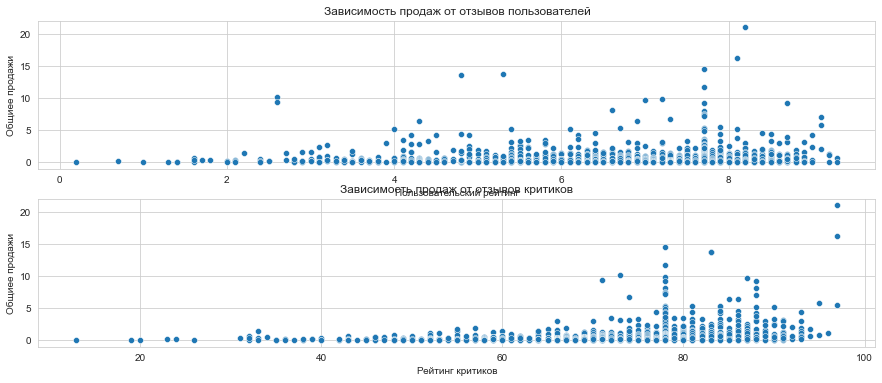

In [44]:
# диаграмма рассеяния 

sns.set_style('whitegrid')
plt.figure(figsize = (15,6))

plt.subplot(2, 1, 1)
scatter1 = sns.scatterplot(data=df_other, x='user_score', y='total_sales') 
scatter1.set_title('Зависимость продаж от отзывов пользователей')
scatter1.set_xlabel('Пользовательский рейтинг')
scatter1.set_ylabel('Общиее продажи')
display(scatter1)

plt.subplot(2, 1, 2)
scatter2 = sns.scatterplot(data=df_other, x='critic_score', y='total_sales') 
scatter2.set_title('Зависимость продаж от отзывов критиков')
scatter2.set_xlabel('Рейтинг критиков')
scatter2.set_ylabel('Общиее продажи')
display(scatter2)

В целом, наблюдаем ту же самую картину, как по популярной платформе.

### Посмотрим на общее распределение игр по жанрам. 

In [45]:
# сформируем сводную таблицу по жанрам

df_genre = df_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum']).reset_index()
df_genre.columns = ['genre','total_sales']
df_genre = df_genre.sort_values(by='total_sales', ascending=False)

<AxesSubplot:title={'center':'Количество проданных игр в зависимости от жанра'}, xlabel='Жанр', ylabel='Общие продажи'>

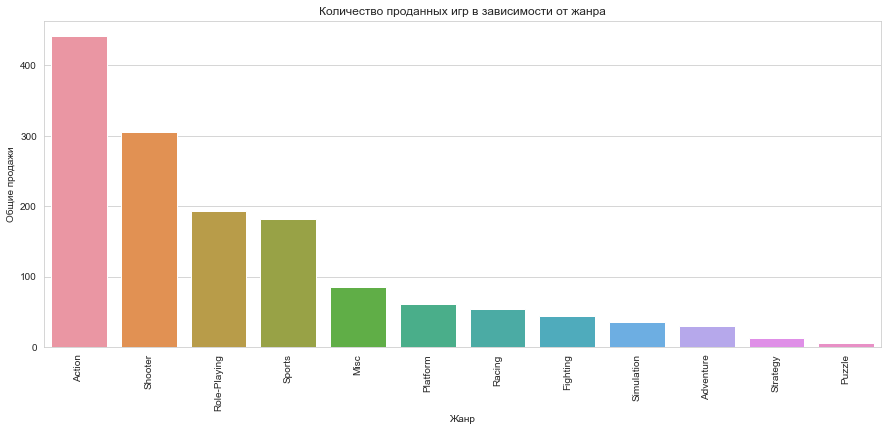

In [46]:
# построим столбчатую диаграмму 
sns.set_style('whitegrid')
plt.figure(figsize = (15,6))

bar = sns.barplot(data = df_genre, 
            x = 'genre',
            y = 'total_sales'
           )
plt.xticks(rotation=90)


bar.set_title('Количество проданных игр в зависимости от жанра')
bar.set_xlabel('Жанр')
bar.set_ylabel('Общие продажи')

display(bar)


Наиболее продаваемые жанры - это Экшен и Стрелялки, на втором месте по популярности идут роллевые компьютерные игры и спортивны. Хуже всего продаются игры-головоломки (возможно, потому что большинство людей играют, чтобы расслабиться и не думать). Все остальные жанры больше на любителя и будут популярны в более "узких кругах", а значит, надо делать ставку в первую очередь на первые 4 жанра игр. 

<AxesSubplot:title={'center':'Количество проданных игр в зависимости от жанра'}, xlabel='Жанр', ylabel='Общие продажи'>

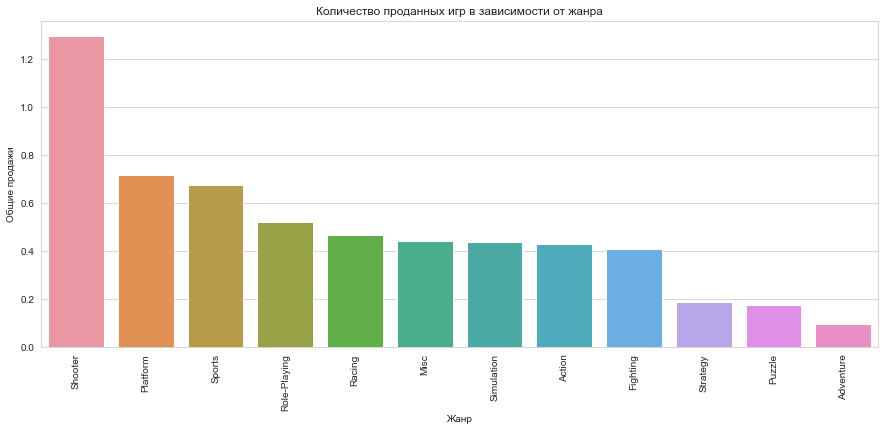

In [47]:
# сформируем сводную таблицу по жанрам

df_genre_mean = df_actual.pivot_table(index='genre', values='total_sales', aggfunc=['mean']).reset_index()
df_genre_mean.columns = ['genre','total_sales']
df_genre_mean = df_genre_mean.sort_values(by='total_sales', ascending=False)

# построим столбчатую диаграмму 
sns.set_style('whitegrid')
plt.figure(figsize = (15,6))

bar = sns.barplot(data = df_genre_mean, 
            x = 'genre',
            y = 'total_sales'
           )
plt.xticks(rotation=90)


bar.set_title('Количество проданных игр в зависимости от жанра')
bar.set_xlabel('Жанр')
bar.set_ylabel('Общие продажи')

display(bar)


**Вывод**

На основании исследовательского анализа в качестве актуальногопериода был выбран временной промежуток с 2012 г., так как начиная именно с этого момента продажи стабилизировались и стали находиться примерно на том уровне, на котором были в текущем году, а значит для прогноза на 2017 г. наиболее информативными для нас будут именно последние годы со стабильной динамикой. Можно предположить, что в этот период в структуре спроса на рынке произошли какие-то изменения. При этом по продажам в этот период лидируют платформы PS4, XOne, 3DS. Однако, между продажами игр и рейтингами пользователей/критиков наблюдается слабая корреляция. Тем не менее, для рейтингов критиков отмечается положительная корреляция, то есть чем больше значения критиков, тем выше продажи. Наиболее востребованы игры в жанрах экшен и стрельбы, а наименее - жанр головоломки.

## Портрет пользователя в зависимости от региона

### North America. Портрет региона.

* Топ-5 популярных платформ:

In [48]:
df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head()

platform
X360   140.05
PS4    108.74
PS3    103.38
XOne    93.12
3DS     55.31
Name: na_sales, dtype: float64

Можно увидеть, что в Северной Америке наиболее популярными являются платформы Xbox и PlayStation - американского и японского производства. Пятую строчку занимает платформа от Nintendo.

* Топ-5 популярных жанров: 

In [49]:
df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head()

genre
Action         177.84
Shooter        144.77
Sports          81.53
Role-Playing    64.00
Misc            38.19
Name: na_sales, dtype: float64

Можно увидеть, что в Северной Америке наиболее популярными являются жанры Экшен и Стрелялки.

* Влияние рейтинга ESRB на продажи:

In [50]:
df_actual.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head()

rating
M         231.57
E         114.37
unknown   103.31
E10+       75.70
T          66.02
Name: na_sales, dtype: float64

Можно увидеть, что в Северной Америке наиболее популярными являются игры в категории «M» («Mature») — «Для взрослых», а также «E» («Everyone»).

### European Union. Портрет региона.

* Топ-5 популярных платформ:

In [51]:
df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head()

platform
PS4    141.09
PS3    106.86
X360    74.52
XOne    51.59
3DS     42.64
Name: eu_sales, dtype: float64

Можно увидеть, что в Европейском союзе наиболее популярными являются платформы PlayStation. Чуть менее популярны платформы Xbox. Пятую строчку занимает платформа от Nintendo.

* Топ-5 популярных жанров: 

In [52]:
df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head()

genre
Action         159.34
Shooter        113.47
Sports          69.09
Role-Playing    48.53
Racing          27.29
Name: eu_sales, dtype: float64

Можно увидеть, что в Европейском союзе наиболее популярными являются Экшен и Стрелялки.

* Влияние рейтинга ESRB на продажи:

In [53]:
df_actual.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head()

rating
M         193.96
E         113.03
unknown    91.50
E10+       55.37
T          52.96
Name: eu_sales, dtype: float64

Можно увидеть, что в Европейском союзе наиболее популярными являются игры в категории «M» («Mature») — «Для взрослых», а также «E» («Everyone»).

### Japan. Портрет региона.

* Топ-5 популярных платформ:

In [54]:
df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head()

platform
3DS    87.79
PS3    35.29
PSV    21.04
PS4    15.96
WiiU   13.01
Name: jp_sales, dtype: float64

Можно увидеть, что в Японии наиболее популярными являются платформы PlayStation и Nintendo, то есть платформы от местного производителя. 

* Топ-5 популярных жанров: 

In [55]:
df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()

genre
Role-Playing   65.44
Action         52.80
Misc           12.86
Simulation     10.41
Fighting        9.44
Name: jp_sales, dtype: float64

Можно увидеть, что в Японии наиболее популярными являются Компьютерная ролевая игра и Экшен. 

* Влияние рейтинга ESRB на продажи:

In [56]:
df_actual.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head()

rating
unknown   108.84
E          28.33
T          26.02
M          21.20
E10+        8.19
Name: jp_sales, dtype: float64

Можно увидеть, что в Японии наиболее популярными являются игры в категории «E» («Everyone») — «Для всех» и «T» («Teen») — «Подросткам».

Что касается рейтинга `unknown`, нужно принять во внимание, что в Японии другая рейтинговая система - CERO. Значит показатель ESRB для них нерепрезентативен, так как выставляется организацией другой страны (в разных странах оценка может разниться) и, вероятно, не охватывает все игры, а также их оценки не полностью идентичны между собой. Кроме того, в Японии сильный локальный рынок, т.е. любят играть в местные игры. Как результат могло появиться большое число пропусков по данной рейтинговой системе.

**Вывод**

По итогу анализа для регионов, можно увидеть, что нет значимых различий в результате для региона Северной Америки и Евросоюза: в обоих регионах наиболее популярны являются платформы Xbox и PlayStation, то есть как американского, так и японского производства; в обоих регионах наиболее популярными являются жанры экшен и стрелялки, то есть наиболее динамичные ~и зачастую не самые гуманные~; в обоих регионах наиболее популярными рейтингами ESRB являются игры «Для взрослых», возможно, как результат выбора жанра игр, а также «Для всех», возможно как наиболее массовый рейтинг.

В то же время в Японии наиболее популярными являются платформы именно национального производства - PlayStation и Nintendo. Набор популярных в Японии жанров также отличается от предыдущих 2х регионов - здесь наиболее популярны компьютерные ролевые игры и экшен. В целом же список топ-5 жанров сильно отличается, и вместо спорта и гонок можно также увидеть симуляции. Можно предположить, что здесь играет роль разница менталитетов. То есть условно мы говорим о портрете среднего покупателя западного рынка и восточного, которые очень различаются. При этом, можно отметить, что наиболее продаваемые по рейтингу ESRB являются рейтинги с менее жесткими возрастными ограничениями: «Для всех» и «Подросткам».

## Проверка гипотез.

Проверим следующие гипотезы: 

### Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые

$ H_{0}: \mu_{XOne} = \mu_{PC} $

$ H_{1}: \mu_{XOne} \neq \mu_{PC} $

Проверим двустороннюю гипотезу для нескольких традиционно используемых уровнях значимости:

In [58]:
# критический уровень статистической значимости
alphas = [0.1, 0.05, 0.01]  

results = st.ttest_ind(df_xone['user_score'], df_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

for alpha in alphas:
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу на {:.0%} уровне значимости'.format(alpha))
    else:
        print('Не получилось отвергнуть нулевую гипотезу на {:.0%} уровне значимости'.format(alpha)) 


p-значение: 0.22684132300789353
Не получилось отвергнуть нулевую гипотезу на 10% уровне значимости
Не получилось отвергнуть нулевую гипотезу на 5% уровне значимости
Не получилось отвергнуть нулевую гипотезу на 1% уровне значимости


Для выбранных уровней значимости не получается отвергнуть нулевую гипотезу. Выходит, что средний пользовательский рейтинг платформ Xbox One и PC одинаковые.


### Средние пользовательские рейтинги жанров `Action` и `Sports` разные

$ H_{0}: \mu_{Action} = \mu_{Sports} $

$ H_{1}: \mu_{Action} \neq \mu_{Sports} $

Проверим двустороннюю гипотезу для нескольких традиционно используемых уровнях значимости:

In [60]:
# критический уровень статистической значимости
alphas = [0.1, 0.05, 0.01]  

results = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var = False, alternative='greater')

print('p-значение:', results.pvalue)

for alpha in alphas:
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу на {:.0%} уровне значимости'.format(alpha))
    else:
        print('Не получилось отвергнуть нулевую гипотезу на {:.0%} уровне значимости'.format(alpha)) 


p-значение: 1.3052400208128037e-21
Отвергаем нулевую гипотезу на 10% уровне значимости
Отвергаем нулевую гипотезу на 5% уровне значимости
Отвергаем нулевую гипотезу на 1% уровне значимости


Для выбранных уровней значимости отвергаем нулевую гипотезу. Вывод — средние пользовательские рейтинги жанров `Action` и `Sports` и правда различаются. 

Проверим теперь, какая из них статистически значимо больше:

### Средние пользовательские рейтинги жанра `Action` больше, чем `Sports`


Данная гипотеза была сформулирован на основании предудущего анализа, а именно того факта, что жанр `Action` в регионах более популярный, нежели жанр `Sports`, а значит его средние оценки, верояно, будут выше. 

$ H_{0}: \mu_{Action} \leq \mu_{Sports} $

$ H_{1}: \mu_{Action} > \mu_{Sports} $

In [61]:
# критический уровень статистической значимости
alphas = [0.1, 0.05, 0.01]  

results = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

for alpha in alphas:
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу на {:.0%} уровне значимости'.format(alpha))
    else:
        print('Не получилось отвергнуть нулевую гипотезу на {:.0%} уровне значимости'.format(alpha)) 


p-значение: 1.3052400208128037e-21
Отвергаем нулевую гипотезу на 10% уровне значимости
Отвергаем нулевую гипотезу на 5% уровне значимости
Отвергаем нулевую гипотезу на 1% уровне значимости


Для выбранных уровней значимости отвергаем нулевую гипотезу. Вывод — cредние пользовательские рейтинги жанра `Action` больше, чем `Sports`.

Это может объясняться предпочтениями этого жанра в большинстве регионов - игры этого жанра являются наиболее продаваемыми. Раз на них наблюдается наибольший спрос, то, вероятно, людям они нравятся, а значит получают более высокие оценки. При этом это может быть также и результат просто более большой выборки.

**Вывод**

Для выбранных уровней значимости не получается отвергнуть нулевую гипотезу о том, что средний пользовательский рейтинг платформ Xbox One и PC одинаковые - обе платформы в равной степени отвечают запросам пользователей. 

При этом для выбранных уровней значимости мы отвергаем нулевую гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковы - они различаются. После дополнительного исследования можем сказать, что cредние пользовательские рейтинги жанра `Action` больше, чем `Sports`. Это может объясняться предпочтениями этого жанра в большинстве регионов - игры этого жанра являются наиболее продаваемыми, следовательно и людям они нравятся больше (или большему числу людей), а значит получают более высокие оценки.

## Общий вывод

В ходе работы были выявлены определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. В первую очередь была произведена подготовка данных: названия столбцов приведены к унифицированному виду, обработаны пропуски, проверенно наличие дубликатов, заменены типы данных для некоторых переменных, был расчитан общий объем продаж. 

На основании исследовательского анализа в качестве актуальногопериода был выбран временной промежуток с 2012 г., так как начиная именно с этого момента продажи стабилизировались и стали находиться примерно на том уровне, на котором были в текущем году. Можно предположить, что в этот период в структуре спроса на рынке произошли какие-то изменения. При этом по продажам в этот период лидируют платформы PS4, XOne, 3DS. Однако, между продажами игр и рейтингами пользователей/критиков наблюдается слабая корреляция. Тем не менее, для рейтингов критиков отмечается положительная корреляция, то есть чем больше значения критиков, тем выше продажи. Наиболее востребованы игры в жанрах экшен и стрельбы, а наименее - жанр головоломки.

По итогу анализа для регионов, можно увидеть, что нет значимых различий в результате для региона Северной Америки и Евросоюза: в обоих регионах наиболее популярны являются платформы как американского, так и японского производства; в обоих регионах наиболее популярными являются жанры экшен и стрелялки, а наиболее распространенными рейтингами ESRB являются игры «Для взрослых», возможно, как результат выбора жанра игр, а также «Для всех», возможно как наиболее массовый рейтинг.

В то же время в Японии наиболее популярными являются платформы именно национального производства. Набор популярных в Японии жанров также отличается - здесь наиболее популярны компьютерные ролевые игры и экшен. При этом наиболее продаваемые по рейтингу ESRB являются рейтинги с менее жесткими возрастными ограничениями: «Для всех» и «Подросткам». Можно предположить, что в выявленных различиях по регионам отражаетсяроль разница менталитетов. То есть условно мы говорим о портрете среднего покупателя западного рынка и восточного рынка. 

Наконец, было выявлено, что средний пользовательский рейтинг платформ Xbox One и PC одинаковы - обе платформы в равной степени отвечают запросам пользователей, а средние пользовательские рейтинги жанров Action и Sports - различаются. При этом cредние пользовательские рейтинги жанра `Action` больше, чем `Sports`. Это может объясняться предпочтениями этого жанра во всех трех регионах. 

Таким образом, нам стоит сделать ставку на продвижении игр жанра экшен на таких платформах как PS4, XOne, 3DS